# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 the Bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [6]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [7]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8693.41,8818.71,8562.20,8785.17,37230.58,3.241097e+08,8714.8725


In [8]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [9]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

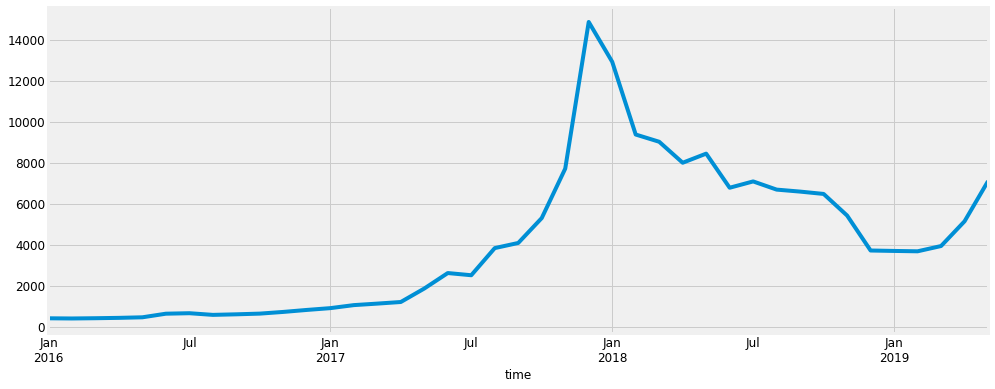

In [10]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated making the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is 



Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

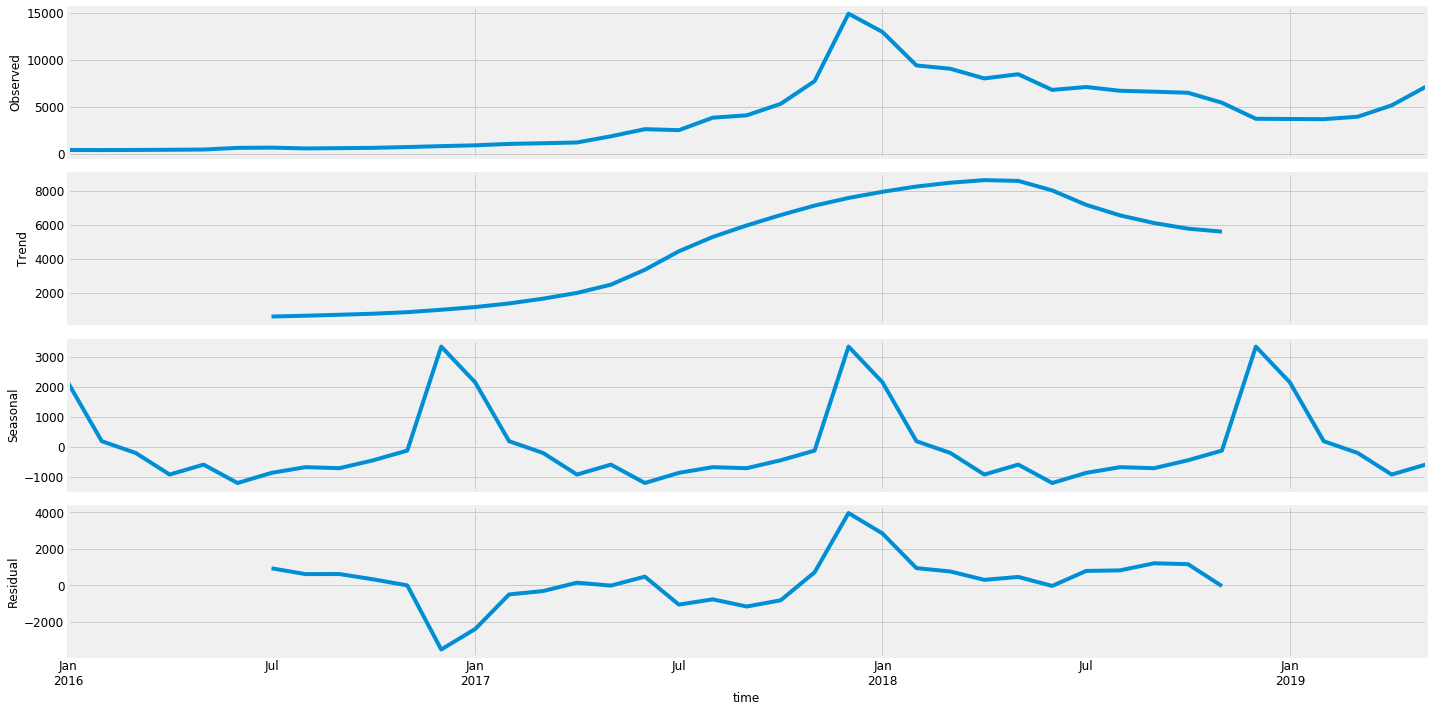

In [11]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [12]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 3)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [13]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.185954878533
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:996.0562781686265
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390220736513
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:344.9425775603844
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326750870962


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:570.5900975619568
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.00990208884434
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:85.52951142771767
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:338.40015590123363


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:340.71834638027116
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:79.572457931272
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0162139019363
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2530.9716845668872
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.3515700054522
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:314.9039891809045
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4156068972592
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:524.1648767917592
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.84268796805407
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:84.85922148470375
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:317.95783401215095
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:317.7719300003251


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:79.07913902115595
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:703.681711220881
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:2339.7547325629253
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:507.7070535512247
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:294.8595644747274
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:545.7990905668258
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:494.4983058925982
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:316.8533465028323
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:87.20550554951218
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:309.8640791922798


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:309.9532966801801


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:89.0192242459256
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:684.9063318458001
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1315.3591524723433
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:506.31507500208477
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:301.041716149576
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:502.4630091371573
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:487.1960080400513
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.7480604441816
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:65.89637159229335
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:276.5566711314347
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:277.6516188016328
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:67.86158446847759
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:668.2038428009567
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2384.131065354566
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:488.7622948718364
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:283.12525782189266
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:502.98669722501864
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.70945782042605
ARIMA(0

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:66.43250219452985
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:653.4082731521921
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:2312.5607910436115
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:473.3882870855972
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:266.8198417548067
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:504.818755695609
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:455.85392888749016
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:276.1225842105586


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:68.44787930100017
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:276.2913610655246


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:271.36759196565936


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:70.28692422371108
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:685.0605928933138
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:1044.292063153884
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:499.60791105034207
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:288.1107764375943
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:497.8881694636342
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:1017.2668476231787
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:261.2188046680328
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:52.83038657189334
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:262.90314851001074
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:661.3101683655425
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:52.670749005024106
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:656.8063785453155
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:1972.311235777002
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:474.45068752658653
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:266.32934722569996
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:488.9585592370596
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:2088.9444198843794
ARI

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:50.308678661626544
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:640.2954134071558
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:1896.7467825641322
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:457.9087224733352
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:249.08722835790556
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:489.6514382414192
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:2064.7595224907886
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:253.15417997597464
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:67.06958147371293
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:253.41710391474157


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:738.0718270338457


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:61.15773661960108
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.245206274461
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1346.8404886160442
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:524.5396828274995
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:321.3208806990723
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:506.06572127059377
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:506.36779769018347
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:271.5943084574516
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:67.36209991687909
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:268.91284892606603


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:270.036899187092


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:69.75298575598825
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:686.2741996283567
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2225.1998260688306
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:506.1920915767204
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:302.7502769609127
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:505.8777587469871
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:489.6354927557651
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:263.62809664313255


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:69.20902339198408
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:277.54710633201853
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:279.5460078173315


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:72.47269319020874
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:671.6361367031782
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:22825690.760606926
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:491.04362073085775
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:286.66288606543526
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:506.9429533464517
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:474.7782860833862
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:295.0634782374135


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:71.38814897420532


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:269.8349707609914


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:282.07500182498035


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:83.03631393731473
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:685.1820589497418
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:150019163636.0873
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:506.8115967747827
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:302.1757174468875
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:486.61329613644494
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:488.3618331224887
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.28442704295065
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:49.44529875407084
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:248.9572053859807
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:249.46746827613597


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:23.397405249292262
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:670.062726518269
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.6662716877707
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:285.05219647641786
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:487.6555943724041
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:472.5860005286604
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:248.49697422692188
ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:57.79857971788292
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:248.33330308682397


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:251.6078856180112


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:51.689506785831405
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:655.5736889461242
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:2077.0237048806966
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:474.51426461570884
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:268.4469231083176
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:489.0148613243049
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:457.1166410860616
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:245.85019787301525


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:42.28104807569717
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:247.88458248417987


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:251.73922551791503


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:54.75260087787842
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:683.5322377209021


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:993.7363989820626
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:499.3287712947467
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:288.7916274635215
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:480.1983345835096


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:1001.8074380522118
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:233.24271244875484
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:44.684496623970105
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:235.19588005786952


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:606.859684655172
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:43.943557248950924
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:657.0745881079188
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:2143.3030883263314
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:475.7573545784882
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:267.55595264649384
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:473.28760025771015
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:13207.10785951833
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:233.53333148386798
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:46.75774610021657
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:235.17702018786295


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:611.656292445563


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:44.869619301240064
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:640.3699940556605
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:2162.5620738714833
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:459.8113356495329
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:250.99800275123863
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:473.88391201223226
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:1976.8337042236085
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:234.1893926924221


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:48.256971086632944


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:238.88720938384733


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:610.1147228715469


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:38.20003140322269
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:686.7602138057455
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1371.0415853514726

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:506.36801329022865
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:302.7991793640782
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:490.29033043244004
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:490.24338684985753
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:247.9599152044191
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:64.35978948418001
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:246.3982686185686


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:251.79312285627552


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:62.55062852845346
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:688.205035373156
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:2219.8516302007265
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:508.18458804816663
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:304.74746083589764
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:491.3411965881706
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:491.49067137685165


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:248.4807481786563
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:66.7455427171148


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:247.49584837461572


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:263.4063367404275
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:64.80874744874478
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:673.8997952365884
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:341098542.05066395
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:492.40819333263073
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:287.00046312493095
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:490.83997032925436
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:476.7799273428453


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:273.0184596009109


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:69.56777087245902


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:265.305843181949


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:267.27087459203676


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:67.22690180845753
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:669.6571761900584
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1499.889384321712
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:490.4762031363915
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:284.88785276850984
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:470.9336292633285
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:472.53864331045423
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:231.36664207109354
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:45.841096207567695
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:232.8804088141685


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:234.96819453186734
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:40.53678544905055
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:671.7046117431984
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:5467.870885607021
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:492.51782241762623
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:286.9878442314517
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:472.8947424025942
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:474.4294348769835
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:232.13296951475797
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:48.12794668473751
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:231.04885193407847


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:232.96455220456622


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:46.769733534503345
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:656.9814238207064
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:2200.5197338854027
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:475.4835411280391
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:270.4486362433938
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:474.0238852556736
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:459.5950165623789


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:248.87504150327356
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:50.792184056337135

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:228.87776532301854


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:247.7785239594369


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:49.7498659195513
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:663.9755855719281


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:986.6759807548332
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:479.4853195473482
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:269.38816325660963
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:461.8582224783259


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:942.6278203834895
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:217.42781040719254
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:27.260627809539283
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:218.86141777199094


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:552.5914372676557
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:27.939412787756478
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:656.9849408786922
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:1974.30688677277
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:476.37185411391715
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:269.14384736870227
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:457.42217773523106
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:2146.593121936571
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:219.30892203440243
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:29.359063300304385


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:220.77704320646686


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:508.1568093116727
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:29.95695253825649
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:643.6747560088712
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:30074.037364714797
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:461.73290628397444
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:252.9474619239939
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:458.6926032566043
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:1898.8170262051815


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:234.06074276470727
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:31.66686208586078


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:221.46968895123194
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:560.8891843326185
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:32.08410889378854


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
# After trying our diffrent fits for our model, we pick the one with the lowest AIC.
# This what is supposed to make our model the most precise.
# Here we insert the order we find above.
model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.642
Date:                            Tue, 28 May 2019   AIC                            247.284
Time:                                    23:09:45   BIC                            249.409
Sample:                                01-01-2016   HQIC                           247.262
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


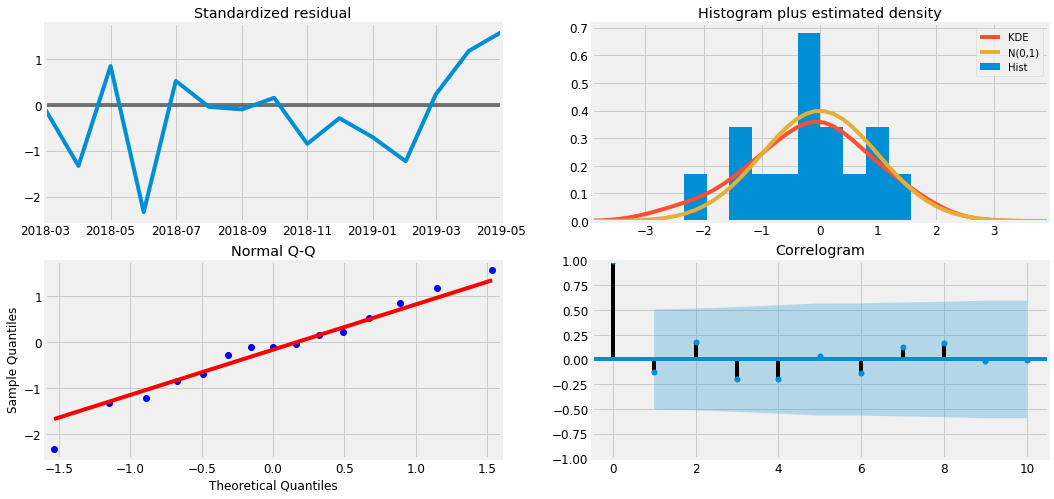

In [15]:
# Plotting model diagnostics to investigate unusual behavior.
# If the graph shows unusual behavior, it is a good sign of need for model improvement.

# Top-right shows a plot of standard notation for a normal distribution, N(0,1).
# Our model is indicated by the red line, KDE.
# This shows a overall normally distributed residuals.

# Bottom-left shows a plot of how residuals are distributed when following a trend. The red line shows a normal distribution.
# Blue dots idicate our model, which has very few outliers from the normal distribution.
# This is overall a pretty good result.

# Bottom-right shows a correlogram which plots the autocorrelation, which shows how residuals have correlation to lagged versions of itself.
# This result is not totally clear to us, so we can not draw any conclusion from it.
# However, it seems like there appear to be no correlation.

# Top-left shows residuals over time. In this case, 1 year and 2 months.
# The standardized residual seems to be white noise - it is hard to find any seasonality from the diagram.

results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

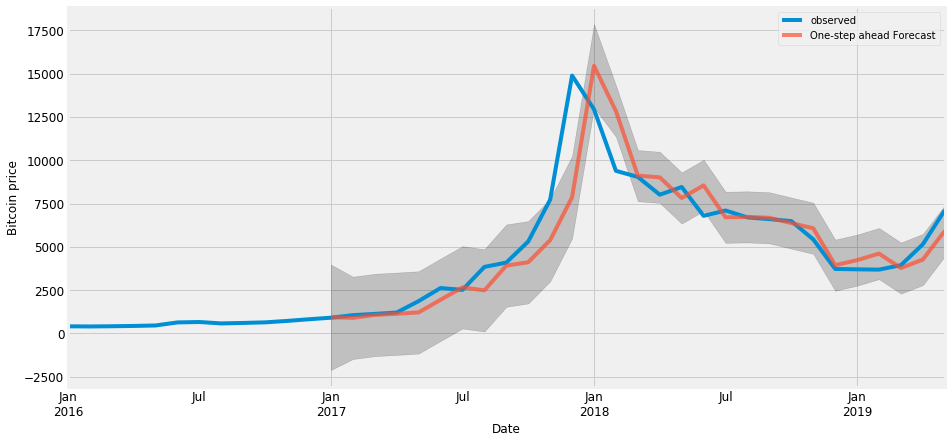

In [16]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts highst and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [17]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.261043           3976.904582
2017-02-01          -1479.273811           3277.094816
2017-03-01          -1311.069410           3442.779443
2017-04-01          -1240.848761           3512.997978
2017-05-01          -1162.979530           3590.867202
2017-06-01           -434.158886           4319.687846
2017-07-01            284.832444           5038.679175
2017-08-01            111.180337           4865.027069
2017-09-01           1539.387705           6293.234437
2017-10-01           1734.723141           6488.569873
2017-11-01           3010.702949           7764.549549
2017-12-01           5489.864316          10243.571105
2018-01-01          13045.659694          17867.615863
2018-02-01          11366.470017          14323.347503
2018-03-01           7638.979276          10590.126264
2018-04-01           7538.873694          10490.020682
2018-05-01

In [18]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5616864356672


## Future prediction

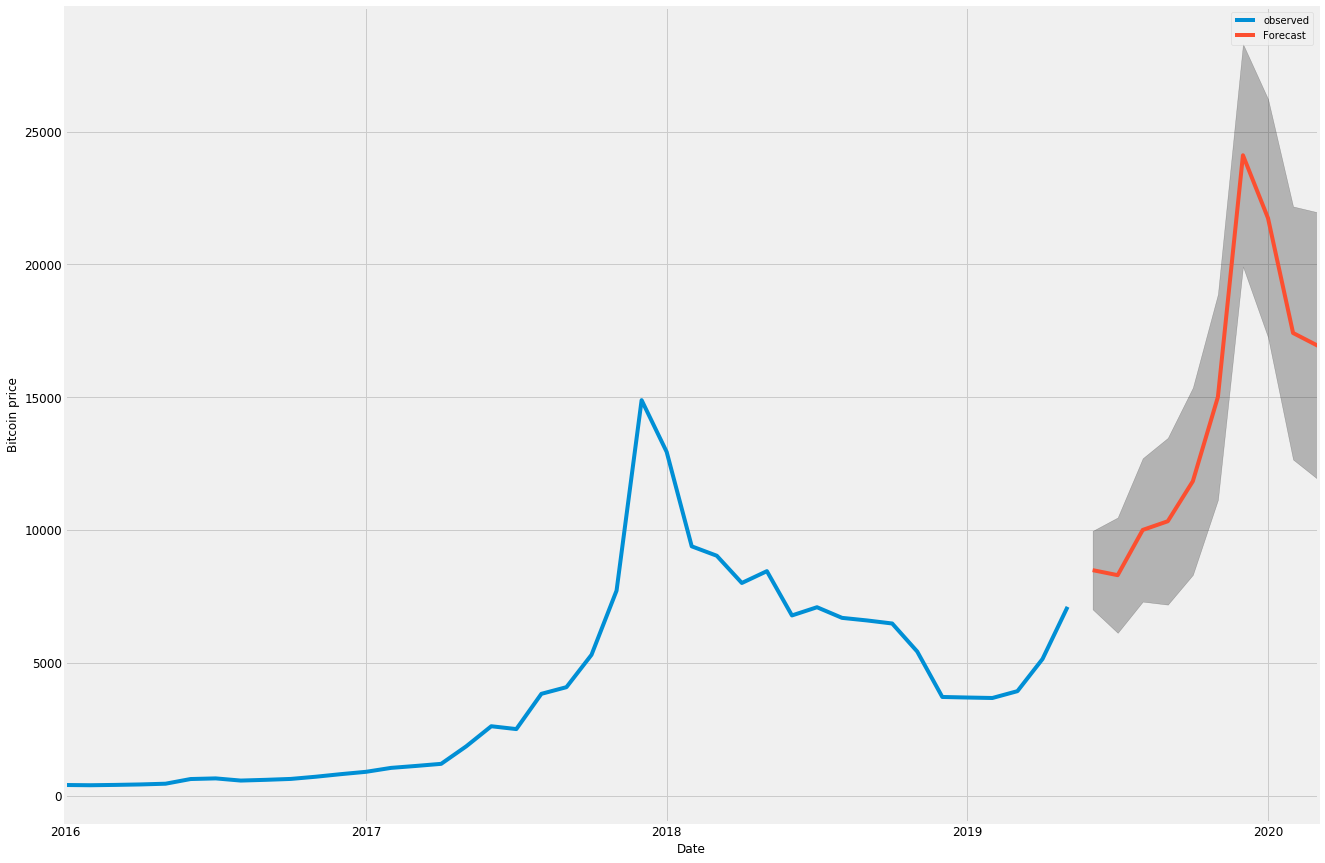

In [19]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=10)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [20]:
# Plotting the result in USD
future_pred.predicted_mean

2019-06-01     8496.379614
2019-07-01     8306.781577
2019-08-01    10009.027333
2019-09-01    10335.547636
2019-10-01    11841.496710
2019-11-01    15010.804041
2019-12-01    24107.017026
2020-01-01    21740.727375
2020-02-01    17419.863867
2020-03-01    16932.898715
Freq: MS, dtype: float64

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However, this also means that in the future it will predict the price to rise dramatically, like it did at some point in the training set.

---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

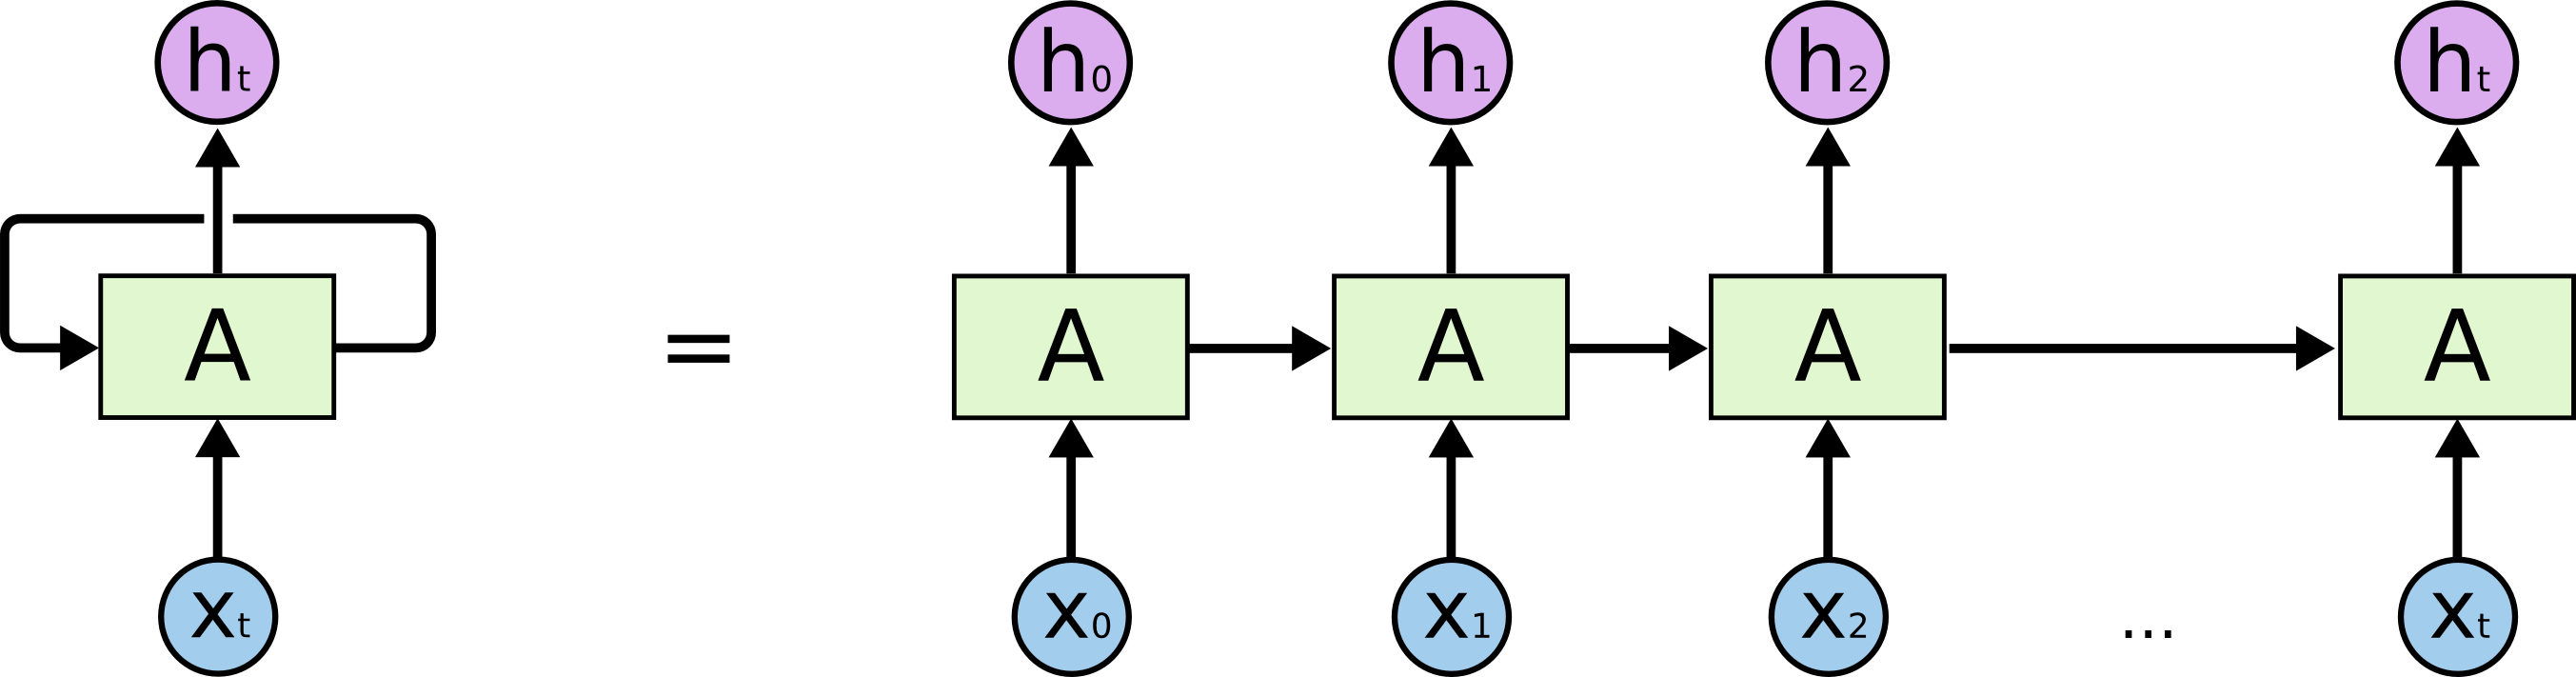


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [21]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [22]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [23]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [25]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [26]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 128 nodes
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a dropout layer of 0.2 to prevent overfitting.
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 46s 29ms/step - loss: 0.0811 - val_loss: 0.2683
Epoch 2/300
1599/1599 [==============================] - 0s 186us/step - loss: 0.0791 - val_loss: 0.2592
Epoch 3/300
1599/1599 [==============================] - 0s 150us/step - loss: 0.0757 - val_loss: 0.2537
Epoch 4/300
1599/1599 [==============================] - 0s 162us/step - loss: 0.0708 - val_loss: 0.2381
Epoch 5/300
1599/1599 [==============================] - 0s 177us/step - loss: 0.0689 - val_loss: 0.2277
Epoch 6/300
1599/1599 [==============================] - 0s 149us/step - loss: 0.0655 - val_loss: 0.2165
Epoch 7/300
1599/1599 [==============================] - 0s 157us/step - loss: 0.0616 - 

1599/1599 [==============================] - 0s 142us/step - loss: 0.0052 - val_loss: 0.0088
Epoch 69/300
1599/1599 [==============================] - 0s 142us/step - loss: 0.0070 - val_loss: 0.0091
Epoch 70/300
1599/1599 [==============================] - 0s 150us/step - loss: 0.0093 - val_loss: 0.0086
Epoch 71/300
1599/1599 [==============================] - 0s 145us/step - loss: 0.0078 - val_loss: 0.0130
Epoch 72/300
1599/1599 [==============================] - 0s 141us/step - loss: 0.0055 - val_loss: 0.0090
Epoch 73/300
1599/1599 [==============================] - 0s 142us/step - loss: 0.0053 - val_loss: 0.0085
Epoch 74/300
1599/1599 [==============================] - 0s 141us/step - loss: 0.0053 - val_loss: 0.0084
Epoch 75/300
1599/1599 [==============================] - 0s 142us/step - loss: 0.0056 - val_loss: 0.0088
Epoch 76/300
1599/1599 [==============================] - 0s 139us/step - loss: 0.0046 - val_loss: 0.0086
Epoch 77/300
1599/1599 [==============================] - 0

Epoch 145/300
1599/1599 [==============================] - 0s 136us/step - loss: 0.0077 - val_loss: 0.0098
Epoch 146/300
1599/1599 [==============================] - 0s 136us/step - loss: 0.0073 - val_loss: 0.0095
Epoch 147/300
1599/1599 [==============================] - 0s 136us/step - loss: 0.0060 - val_loss: 0.0096
Epoch 148/300
1599/1599 [==============================] - 0s 139us/step - loss: 0.0082 - val_loss: 0.0100
Epoch 149/300
1599/1599 [==============================] - 0s 135us/step - loss: 0.0058 - val_loss: 0.0086
Epoch 150/300
1599/1599 [==============================] - 0s 137us/step - loss: 0.0062 - val_loss: 0.0090
Epoch 151/300
1599/1599 [==============================] - 0s 141us/step - loss: 0.0065 - val_loss: 0.0105
Epoch 152/300
1599/1599 [==============================] - 0s 139us/step - loss: 0.0054 - val_loss: 0.0085
Epoch 153/300
1599/1599 [==============================] - 0s 139us/step - loss: 0.0059 - val_loss: 0.0087
Epoch 154/300
1599/1599 [============

1599/1599 [==============================] - 0s 149us/step - loss: 0.0051 - val_loss: 0.0085
Epoch 222/300
1599/1599 [==============================] - 0s 142us/step - loss: 0.0053 - val_loss: 0.0089
Epoch 223/300
1599/1599 [==============================] - 0s 150us/step - loss: 0.0068 - val_loss: 0.0100
Epoch 224/300
1599/1599 [==============================] - 0s 147us/step - loss: 0.0068 - val_loss: 0.0095
Epoch 225/300
1599/1599 [==============================] - 0s 136us/step - loss: 0.0089 - val_loss: 0.0099
Epoch 226/300
1599/1599 [==============================] - 0s 149us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 227/300
1599/1599 [==============================] - 0s 143us/step - loss: 0.0062 - val_loss: 0.0084
Epoch 228/300
1599/1599 [==============================] - 0s 147us/step - loss: 0.0048 - val_loss: 0.0086
Epoch 229/300
1599/1599 [==============================] - 0s 150us/step - loss: 0.0055 - val_loss: 0.0089
Epoch 230/300
1599/1599 [==========================

1599/1599 [==============================] - 0s 137us/step - loss: 0.0050 - val_loss: 0.0090
Epoch 298/300
1599/1599 [==============================] - 0s 139us/step - loss: 0.0067 - val_loss: 0.0097
Epoch 299/300
1599/1599 [==============================] - 0s 142us/step - loss: 0.0067 - val_loss: 0.0108
Epoch 300/300
1599/1599 [==============================] - 0s 141us/step - loss: 0.0077 - val_loss: 0.0124


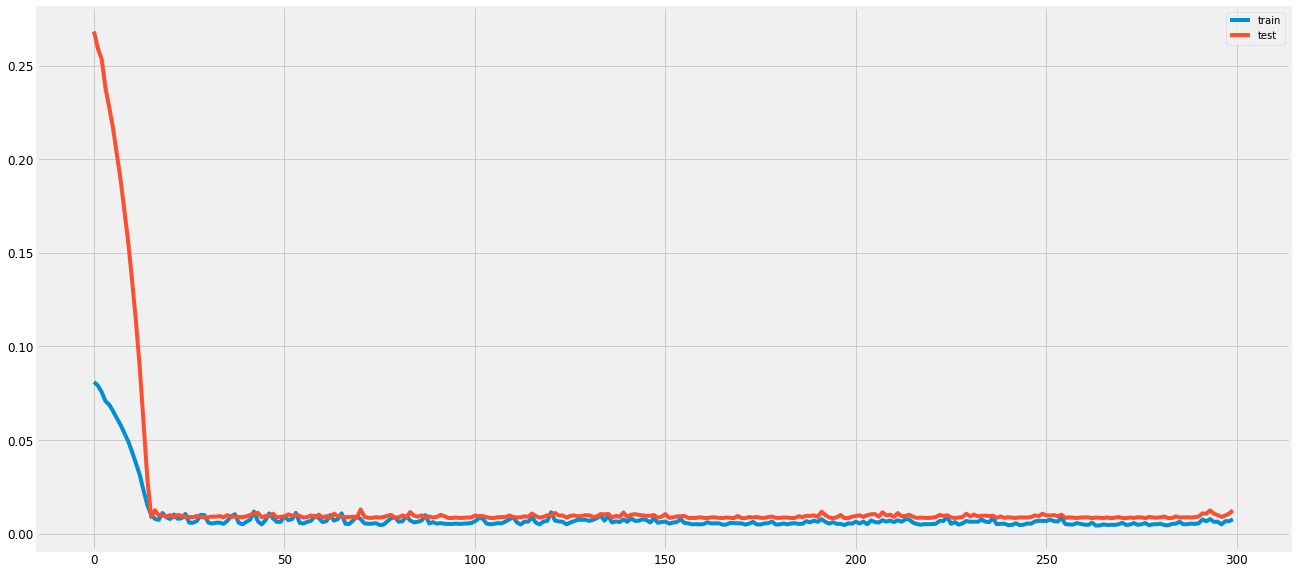

In [27]:
# Plotting the training loss vs the test validation loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

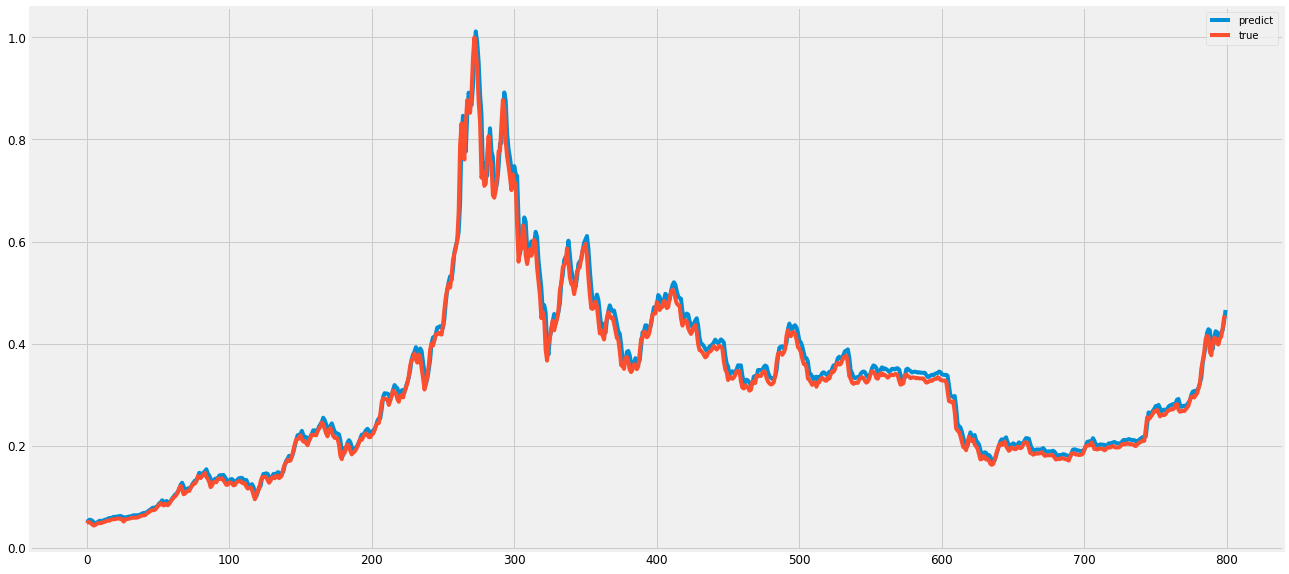

In [28]:
# We predict the values from testX.
yhat = model.predict(testX)

# Plotting the actual graph vs the predicted graph.
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [29]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1090.9797]
[1033.165]


In [30]:
# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Mean absolute error',mae)

Mean absolute error 238.262


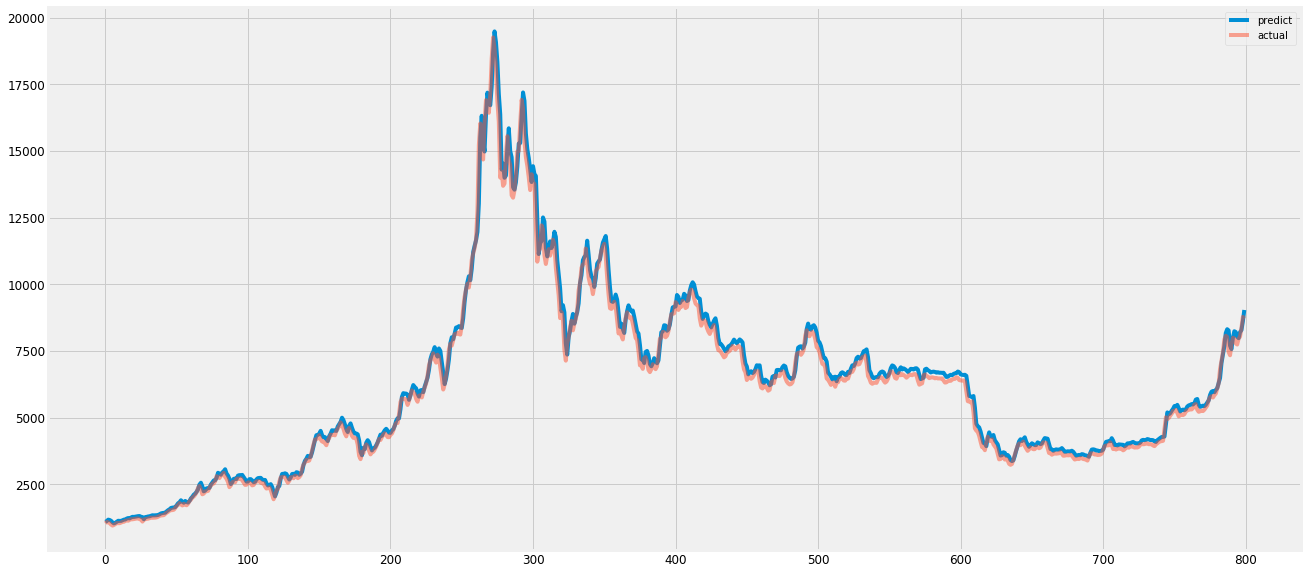

In [31]:
# Plotting prediction vs actual graph.
# This plotting shows the price.
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [32]:
# Creating a new variable containing the testX values.
# Just for good measure.
Xtest = testX

# Predicting the values from Xtest and appending the last preicted value
# to the set before predicting again
for i in range(30):
    future_preds = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    
    y = np.zeros((1,1,1))
    y[[0]] = future_preds[len(future_preds)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)

In [33]:
future_preds_inverse = scaler.inverse_transform(future_preds.reshape(-1, 1))

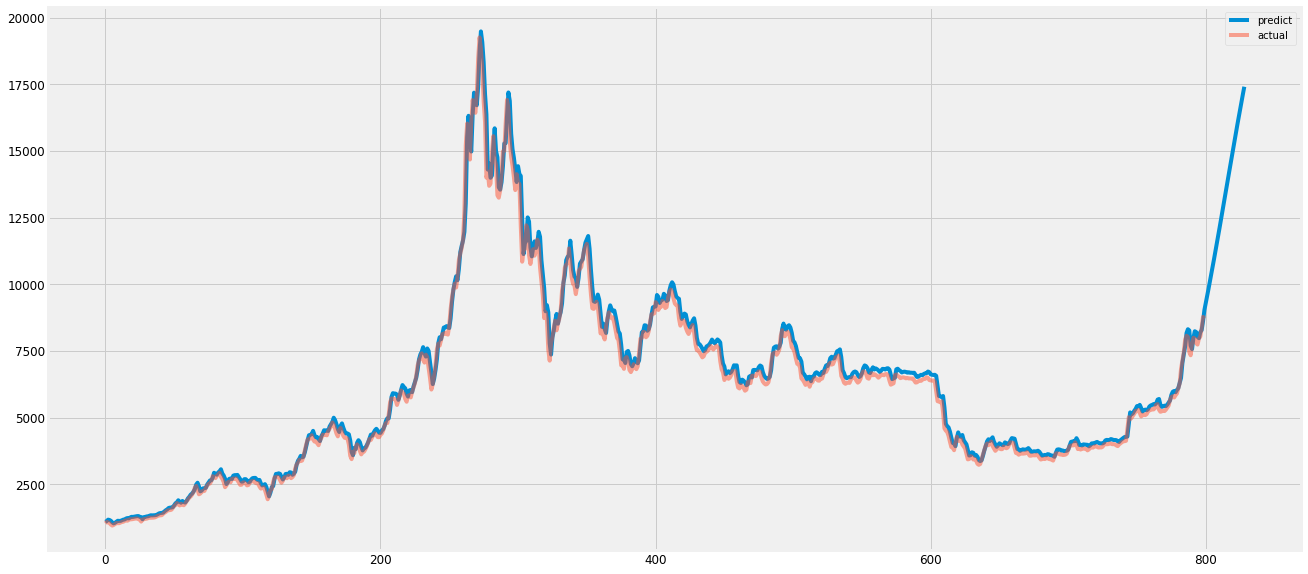

In [34]:
plt.plot(future_preds_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)

plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)

# Conclusion

By looking at the the plotted predictions compared to the actual values, and by looking at the mean absoluted error (MAE), it is very clear, that the best model on paper is our RNN LSTM model. The MAE of the SARIMA model is significantly higher than the one of the RNN LSTM model.However, the RNN LSTM model seems to have a random behaviour when predicting future values, which suggests the model is overfitted.

With this in mind we will save the SARIMA model for future predictions.

In [35]:
# Saving the model
results.save('SARIMA_btc_pred.pkl')

In [38]:
%%writefile aiwebflask.py

# Import libraries
import numpy as np
from sklearn.externals import joblib
from flask import Flask, request, jsonify, render_template
import pickle

# create an instance (our app)
app = Flask(__name__)

results = joblib.load('SARIMA_btc_pred.pkl')

@app.route('/', methods=['GET', 'POST'])
@app.route('/hi/<name>')
def hello(name = None):
    return render_template('index.html', name=name)
# name is parameter in the template: {{name}}

@app.route('/predict')
def predict():
    return render_template('prediction.html')

@app.route('/predicted', methods=['GET', 'POST'])
def predicted():
    if request.method == 'POST':
        months = int(request.form['months'])
        predicted = results.get_forecast(steps=months).predicted_mean
        
        predicted = predicted[len(predicted)-1]

        return render_template("predicted.html", content=months, prediction=predicted)

@app.route('/bye')
def bye():
    return render_template('bye.html')

if __name__ == '__main__':
    app.run(debug=True)

Overwriting aiwebflask.py


In [ ]:
!python aiwebflask.py